In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np

import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

from tqdm import tqdm_notebook as tqdm

import sys 
sys.path.append('..')

from models import SDFNet
from backend.datasets import SDFItemDataset
from backend.datasets.utils import get_weights

import warnings
warnings.filterwarnings('ignore')

### Loading single mesh and corresponding SDF values

In [2]:
plane_mesh = np.load('../../data/plane1_mesh.npy')
plane_sdf = np.load('../../data/plane1_sdf.npy')
plane_sdf = np.expand_dims(plane_sdf,-1)

assert plane_sdf.ndim==2 and plane_sdf.shape[1]==1
assert plane_mesh.ndim==2 and plane_mesh.shape[1]==3

In [3]:
batch_size = 16384
train_steps = 400
val_steps = 200

# random points for validation
val_fraction = 0.35

val_mask = np.zeros((plane_mesh.shape[0]), dtype=np.bool)
val_ind = np.random.choice(range(plane_mesh.shape[0]), int(val_fraction*plane_mesh.shape[0]))
val_mask[val_ind] = 1

train_dataset = SDFItemDataset(plane_mesh[~val_mask], plane_sdf[~val_mask])
val_dataset = SDFItemDataset(plane_mesh[val_mask], plane_sdf[val_mask])

# balanced sampling: 1:1 positive:negative 
weights_train = get_weights(plane_sdf[~val_mask])
weights_val = get_weights(plane_sdf[val_mask])

train_sampler = WeightedRandomSampler(weights_train, batch_size*train_steps)
val_sampler = WeightedRandomSampler(weights_val, batch_size*val_steps)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=4)

In [4]:
model = SDFNet().cuda()

criterion = nn.MSELoss()

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

In [5]:
# to clamp sdf values for both targets and model outputs
def clamp(delta, x):
    return torch.clamp(x, min=-delta, max=delta)

def mse(outputs, targets):
    return ((outputs - targets) ** 2).sum() #taking sum just to track the progress

In [6]:
class SDFTrainer:
    def __init__(self, model, criterion, optimizer, delta=0.1, checkpoints_dir='checkpoints'):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.delta = delta
        os.makedirs(checkpoints_dir, exist_ok=True)
        self.checkpoints_dir=checkpoints_dir
        
    def fit(self, train_loader, val_loader, epochs, save=False):
        best_val_mse = 1e6
        for epoch in range(epochs):
            self._train(train_loader, epoch)
            val_loss, val_mse = self._validate(val_loader)
            if val_mse<best_val_mse:
                best_val_mse = val_mse
                if save:
                    self.save_weights()  
    def save_weights(self, name='model.pth'):
        torch.save(self.model.state_dict(), os.path.join(self.checkpoints_dir, name))

    def load_weights(self, weights_path):
        self.model.load_state_dict(weights_path)
        
    def _validate(self, loader):
        self.model.eval()
        running_loss = []
        running_mse = []
        
        for inputs, targets in loader:
            inputs = inputs.float().cuda()
            targets = targets.float().cuda()

            with torch.set_grad_enabled(False):
                outputs = self.model(inputs)
                loss = criterion(clamp(self.delta, outputs), clamp(self.delta, targets))
                
                running_loss.append(loss.item())
                running_mse.append(mse(outputs, targets).detach().cpu().numpy())
        
        mean_loss = np.mean(running_loss)
        mean_mse = np.mean(running_mse)
        
        print(f'val loss: {mean_loss:.5f}, val mse: {mean_mse:.5f}')
        return mean_loss, mean_mse
        
    def _train(self, loader, epoch):
        self.model.train()
        running_loss = []
        running_mse = []
        tq = tqdm(total=len(loader))
        tq.set_description('Epoch {}'.format(epoch))
        
        for inputs, targets in loader:
            inputs = inputs.float().cuda()
            targets = targets.float().cuda()

            self.optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                outputs = self.model(inputs)
                loss = self.criterion(clamp(delta, outputs), clamp(delta, targets))

            loss.backward()
            self.optimizer.step()

            running_loss.append(loss.item())
            running_mse.append(mse(outputs, targets).detach().cpu().numpy())

            mean_loss = np.mean(running_loss)
            mean_mse = np.mean(running_mse)
                
            tq.update()
            tq.set_postfix(loss='{:.3f}'.format(mean_loss), mse = '{:.3f}'.format(mean_mse))            


In [7]:
epochs = 8
delta = 0.1

sdf_trainer = SDFTrainer(model, criterion, optimizer, delta)
sdf_trainer.fit(train_loader, val_loader, epochs, save=True)

val loss: 0.00008, val mse: 1.37543


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/conda/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




val loss: 0.00003, val mse: 0.56720


val loss: 0.00003, val mse: 0.48614


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/conda/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




val loss: 0.00003, val mse: 0.48055


val loss: 0.00003, val mse: 0.46760


Exception in thread Thread-6:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/conda/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




val loss: 0.00003, val mse: 0.45836


val loss: 0.00003, val mse: 0.42146


Exception in thread Thread-7:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/conda/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




val loss: 0.00003, val mse: 0.42296


## Visualization

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [9]:
def plot_sdf(xyz, sdf, n_display=10000):
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')
    

    ind = np.random.choice(range(xyz.shape[0]), n_display)
    data = xyz[ind].T

    ax.scatter(data[0], data[2], data[1], s=5, c=sdf[ind])
    ax.view_init(20, 100)
    limit = (-0.3, 0.3)
    ax.set_xlim3d(*limit)
    ax.set_ylim3d(*limit)
    ax.set_zlim3d(*limit)

    plt.show()

### Validation GT SDF values

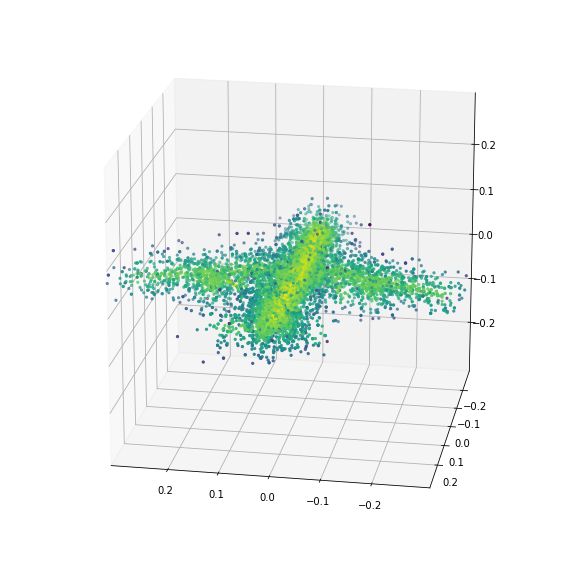

In [10]:
x, y = next(iter(val_loader))
plot_sdf(x.numpy(), y.numpy().squeeze())

In [11]:
sdf_values = model(x.float().cuda()) # model predictions
sdf_values = sdf_values.detach().cpu().numpy()

### Predicted SDF values

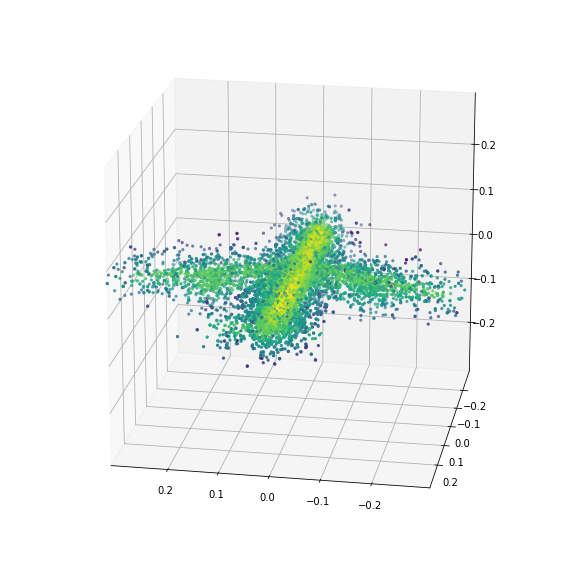

In [12]:
plot_sdf(x.numpy(), sdf_values.squeeze())

### GT shell (surface points)

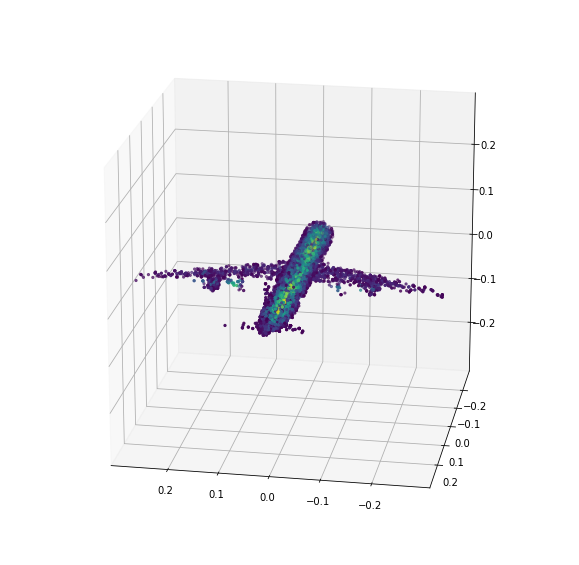

In [13]:
ind = y.squeeze()>=0
plot_sdf(x[ind, :].numpy(), y[ind,:].squeeze())

### Predicted shell

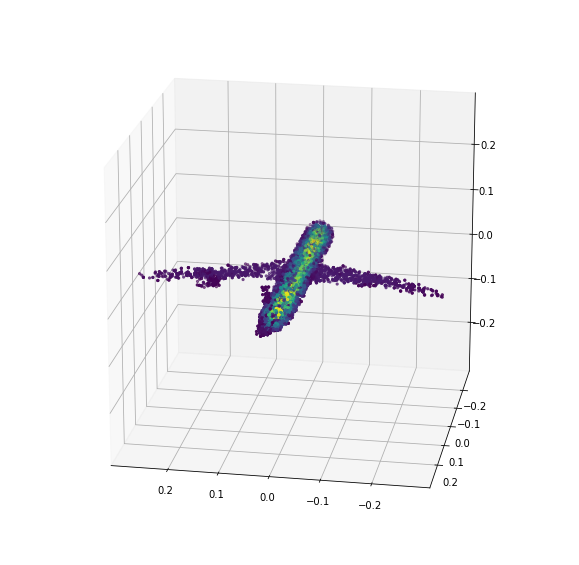

In [14]:
ind = sdf_values.squeeze()>=0
plot_sdf(x.numpy()[ind, :], sdf_values[ind].squeeze())